In [1]:
import pandas as pd

# Carregar os dados de treino
train_data = pd.read_csv('train.csv')
X_train = train_data['comment_text']  # A coluna com os comentários
y_train = train_data.iloc[:, 2:]      # As colunas com as etiquetas de toxicidade

# Carregar os dados de teste
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

# Filtrar as entradas de teste onde as etiquetas não são -1
test_labels = test_labels[test_labels['toxic'] != -1]
X_test = test_data[test_data['id'].isin(test_labels['id'])]['comment_text']
y_test = test_labels.iloc[:, 1:]

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tonil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tonil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.stem import SnowballStemmer

def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]

    # Usando SnowballStemmer
    stemmer = SnowballStemmer("english")

    stemmed_tokens = []
    for token in filtered_tokens:
        try:
            stemmed_token = stemmer.stem(token)
            stemmed_tokens.append(stemmed_token)
        except RecursionError:
            # Caso um erro de recursão ocorra, simplesmente use o token não modificado
            print("erro");
            stemmed_tokens.append(token)

    return " ".join(stemmed_tokens)

In [4]:
X_train_preprocessed = [preprocess_text(text) for text in X_train]

In [5]:
X_test_preprocessed = [preprocess_text(text) for text in X_test]

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train_preprocessed)
X_test_transformed = vectorizer.transform(X_test_preprocessed)

In [7]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression

# Inicializando o classificador de Regressão Logística com n_jobs=-1
base_classifier = LogisticRegression(n_jobs=-1)

# Inicializando o classificador Binary Relevance com o classificador base
br_classifier = BinaryRelevance(classifier=base_classifier, require_dense=[False, True])

# Treinando o modelo
br_classifier.fit(X_train_transformed, y_train)

# Fazendo previsões
y_pred = br_classifier.predict(X_test_transformed)

# Avaliando o modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')


Acurácia: 0.8958704554690675


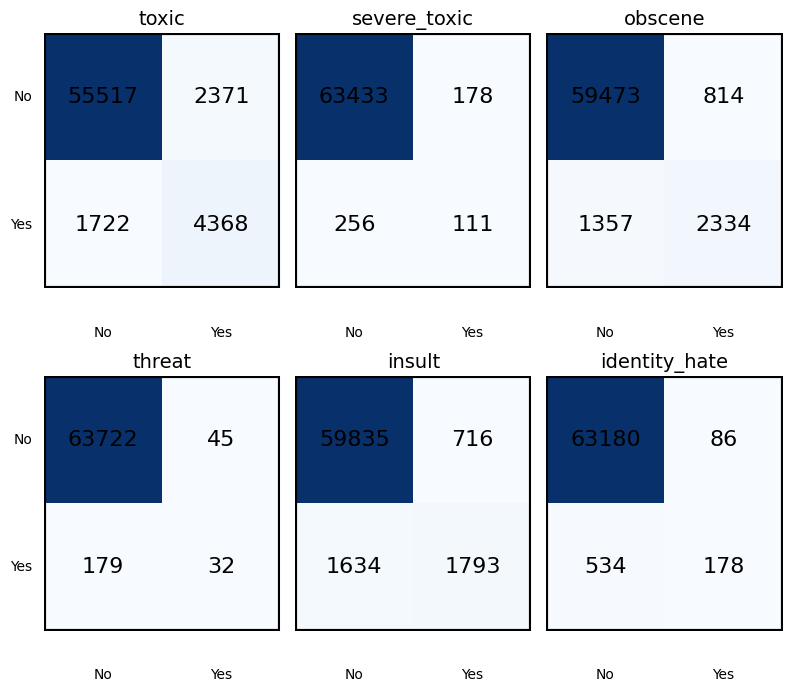

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from matplotlib.patches import Rectangle

# Gerando matrizes de confusão para cada rótulo
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Nomes das classes (rótulos)
class_names = y_test.columns

# Inicializando a figura para a grade de matrizes de confusão
num_rows = int(np.ceil(len(class_names) / 3))
fig, axarr = plt.subplots(num_rows, 3, figsize=(8, 7))  
axes = axarr.flatten()

# Preenchendo a grade com as matrizes de confusão
for i, matrix in enumerate(confusion_matrices):
    axes[i].imshow(matrix, cmap="Blues", aspect='auto')
    axes[i].set_title(class_names[i], fontsize=14)
    
    # Adicionar anotações numéricas
    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            axes[i].text(k, j, str(matrix[j, k]), ha='center', va='center', fontsize=16)
    
    axes[i].axis('off')
    rect = Rectangle((0,0), 1, 1, edgecolor='black', facecolor='none', transform=axes[i].transAxes, linewidth=3)
    axes[i].add_patch(rect)

    # Adicionando rótulos de linha e coluna
    if i % 3 == 0:  # Para a primeira coluna
        for j, cls in enumerate(['No', 'Yes']):  # Substitua por nomes mais apropriados das classes se necessário
            axes[i].text(-0.6, j, cls, ha='right', va='center', color='black', transform=axes[i].transData)

    for j, cls in enumerate(['No', 'Yes']):  # Substitua por nomes mais apropriados das classes se necessário
        axes[i].text(j, 1.9, cls, ha='center', va='bottom', color='black', transform=axes[i].transData)

# Ocultando os eixos não utilizados
for i in range(len(confusion_matrices), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Calculando as métricas para cada rótulo
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Acurácia geral (não por classe, pois a acurácia é uma métrica global)
accuracy_overall = accuracy_score(y_test, y_pred)

# Criando um DataFrame com as métricas
metrics_df = pd.DataFrame({
    'Classe': y_test.columns,
    'Precisão': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

# Criando uma linha para a acurácia geral
accuracy_df = pd.DataFrame({'Classe': ['Acurácia Geral'], 'Precisão': [accuracy_overall], 'Recall': [accuracy_overall], 'F1-Score': [accuracy_overall]})

# Concatenando com a tabela de métricas
metrics_df = pd.concat([metrics_df, accuracy_df], ignore_index=True)

# Exibindo a tabela
print(metrics_df)


           Classe  Precisão    Recall  F1-Score
0           toxic  0.648167  0.717241  0.680957
1    severe_toxic  0.384083  0.302452  0.338415
2         obscene  0.741423  0.632349  0.682556
3          threat  0.415584  0.151659  0.222222
4          insult  0.714627  0.523198  0.604111
5   identity_hate  0.674242  0.250000  0.364754
6  Acurácia Geral  0.895870  0.895870  0.895870
